# **Geospatial Analysis with Machine Learning**


# Imports & Environment Settings


## Imports

<!-- _You may see a message about regarding the use of a Tensorflow binary that is optimized with oneAPI Deep Neural Network Library (oneDNN). There is nothing wrong and it can be safely ignored._ -->

Run the following cell to install and import neccessary libraries for this workflow. A temporary directory is created to store the data and model files.

> Please note that if you rerun this cell, the temporary directory will be deleted and recreated. If you want to keep the data and model files, please copy them to a permanent location before rerunning this cell.


In [1]:
# import libraries & create a temporary working directory in current folder
# !pip install --quiet contextily earthpy fiona geopandas rasterio pyproj keras-spatial spectral
import itertools
import os
import pathlib
import random
import re
import shutil
import time
import warnings
from datetime import datetime
from pathlib import Path

import alphashape
import contextily as cx
import cv2
import earthpy.spatial as es
import fiona as fio
import geopandas as gpd
import imgaug as ia
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np

# from osgeo import gdal
import rasterio
import rasterio as rio
import spectral
import tensorflow as tf
import torch
from imgaug import augmenters as iaa
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.layers import *
from keras.models import *
from keras.optimizers import *
from keras_spatial import SpatialDataGenerator
from rasterio import windows
from rasterio.enums import Resampling
from rasterio.features import rasterize
from rasterio.warp import Resampling, calculate_default_transform, reproject
from shapely.geometry import box
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from multiprocessing import Pool

from lib import *

# import tensorflow_addons as tfa

/Users/nathalieredick/.pyenv/versions/3.10.8/envs/geoML/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
2024-05-12 13:59:20.877410: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
START_TIME = time.time()

# load functions and set global variables
warnings.filterwarnings("ignore")

# data dir for temporary/working files in the current directory
working_dir = os.path.join(".", "working")
os.makedirs(working_dir, exist_ok=True)

print(
    f"{time.ctime()}: Created a temporary working directory in current folder at {working_dir}"
)

tf.get_logger().setLevel("INFO")

# helper functions & global variables for the workflow
PIXEL_SIZE = -1
TILE_SIZE = -1


Sun May 12 13:59:29 2024: Created a temporary working directory in current folder at ./working


## Setting a random seed

### What is a random seed?

A random seed is a number that is used to initialize a pseudorandom number generator. This is used to generate a sequence of numbers that are seemingly random, but are actually deterministic. This is useful for reproducibility, as the same seed will always generate the same sequence of "random" numbers.

In short, this allows the results of this workflow to be reproducible.

Set the random seed to any integer value.


In [3]:
# define a random seed for reproducibility
seed_picker = widgets.IntText(value=42, description="Seed:", disabled=False)

seed_picker

IntText(value=42, description='Seed:')

In [4]:
# set seed
SEED = seed_picker.value

# set `PYTHONHASHSEED` environment variable at a fixed value
os.environ["PYTHONHASHSEED"] = str(SEED)

# set `python` built-in pseudo-random generator at a fixed value
random.seed(SEED)

# set `numpy` pseudo-random generator at a fixed value
np.random.seed(SEED)

# set `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(SEED)

# configure a new global `tensorflow` session
session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

torch.manual_seed(SEED)

# Add Data

## Upload your data


### Features

Features are the inputs the model learns in order to predict a _mask_. For example, if you want to predict the land cover of a region, a feature may be soil type.

Make sure to input all of the files you want to upload at once.

> If you plan to re-run this workflow with the same data, you can expand the cell and and the paths to the `value` parameter, which sets a default value. For example, `value = '...data/feature1.tif,...data/feature2.tif'`.

### Mask

A mask defines the output the model learns to predict. For example, if you want to predict the land cover of a region, the masks would be polygons representing the land cover types.

As of right now, this workflow only supports the ability to predict a single mask.

You can only upload a single **vector** file.

In [5]:
# add the paths to your data files

add_features = widgets.Textarea(
    # value="../data/clayton_diablo_data/clipped_dem.tif",
    value="../data/chile_data/alos_nova_friburgo_5m.tif",
    # value="../data/california_data/dem.tif,../data/california_data/tri.tif,../data/california_data/slope.tif,../data/california_data/roughness.tif",
    # value="../data/drumlin_data/lidar.tif",
    placeholder="File paths (comma-separated)",
    description="Features:",
    disabled=False,
)

add_mask = widgets.Textarea(
    # value="../data/clayton_diablo_data/deposits.geojson",
    value="../data/chile_data/scars.geojson",
    # value='../data/california_data/landslide_deposits.gpkg',
    # value="../data/drumlin_data/mask_rasterized.tif",
    placeholder="File path",
    description="Mask:",
    disabled=False,
)

tabs = widgets.Tab()
tabs.children = [add_features, add_mask]
tabs.set_title(0, "Input Feature Paths")
tabs.set_title(1, "Input Mask Path")

tabs

In [6]:
# copy the input data files to the working directory
mask_path = shutil.copy2(
    add_mask.value, os.path.join(working_dir, pathlib.Path(add_mask.value).name)
)
print(f"{time.ctime()}: Saved a working copy of the mask to {mask_path}.")

feature_paths = []
for f in add_features.value.split(","):
    path = os.path.join(working_dir, pathlib.Path(f).name)
    print(f"{time.ctime()}: Saved a working copy of the feature to {path}.")
    feature_paths.append(path)
    try:
        shutil.copy2(f, path)
    except:
        pass  # ignore if same file

Sun May 12 13:59:30 2024: Saved a working copy of the mask to ./working/scars.geojson.
Sun May 12 13:59:30 2024: Saved a working copy of the feature to ./working/alos_nova_friburgo_5m.tif.


## Set the No Data Value

In [7]:
# check if the data has a nodata value
# default to the mask nodata value if set
# otherwise the first feature nodata value
# otherwise set to 0
nodata = 0

if mask_path.endswith(".tif"):
    for path in [mask_path, *feature_paths]:
        with rio.open(path) as src:
            try:
                nodata = src.nodata
            except:
                nodata = 0

            print(f"{time.ctime()}: {path} has a nodata value of {nodata}.")

            if path == mask_path:
                mask_nodata = nodata
            else:
                feature_nodata = nodata

select_nodata = widgets.IntText(value=nodata, description="No-data:", disabled=False)

select_nodata

IntText(value=0, description='No-data:')

## Select a Coordinate Reference System (CRS)


Input data does not all need to have the same CRS, it will be reprojected to the CRS selected here. The CRS of your mask input will be set to the default value.

This workflow can use any CRS accepted by the function [`pyproj.CRS.from_user_input()`](https://geopandas.org/en/stable/docs/user_guide/projections.html):

- CRS WKT string
- An authority string (i.e. "EPSG:4326")
- An EPSG integer code (i.e. 4326)
- A pyproj.CRS
- An object with a to_wkt method
- PROJ string
- Dictionary of PROJ parameters
- PROJ keyword arguments for parameters
- JSON string with PROJ parameters


For reference, some common projections and their codes:

- WGS84 Latitude/Longitude: "EPSG:4326"
- UTM Zones (North): "EPSG:32633"
- UTM Zones (South): "EPSG:32733"

<!-- TODO add details about what is a CRS (geographic vs projected), which to select, details about why there are limited options, etc -->

In [8]:
# select a CRS
NO_DATA = select_nodata.value

# set a base CRS
default = "EPSG:4326"

# find the CRS from the mask file
try:  # to open the mask file as a polygon
    tmp = gpd.read_file(mask_path)
    default = tmp.crs
except:  # try to open the mask file as a raster
    tmp = rio.open(mask_path)
    default = tmp.crs

print(f"{time.ctime()}: Detected CRS from {mask_path} to be {default}")

select_crs = widgets.Text(
    value=str(default).upper(), description="CRS:", disabled=False
)

select_crs

Sun May 12 13:59:30 2024: Detected CRS from ./working/scars.geojson to be epsg:32723


Text(value='EPSG:32723', description='CRS:')

## Reproject Data

If *necessary*, each of the input features and the mask will be reprojected to the CRS selected above.

If the following cell fails to run, try rerunning the cell. If you are still having issues, you may be using an incompatible CRS for your data.

In [9]:
# convert all data to the same CRS

CRS = select_crs.value  # get the selected CRS from the widget

min_res = -1  # set to negative 1
max_res = np.inf  # set to infinity

# reproject all data to the same CRS
for data in [mask_path, *feature_paths]:
    try:
        reproject_raster(data, data, CRS)
        # calculate the minimum resolution (worst resolution of the data)
        min_res = max(min_res, rio.open(data).res[0])
        # calculate the maximum resolution (best resolution of the data)
        max_res = min(max_res, rio.open(data).res[0])
    except:
        gdf = gpd.read_file(data)
        if gdf.crs == CRS:
            print(f"{time.ctime()}: {data} is already in target CRS.")
        else:
            gdf.to_crs(CRS, inplace=True)
            os.remove(data)
            gdf.to_file(data)

Sun May 12 13:59:30 2024: ./working/scars.geojson is already in target CRS.
Sun May 12 13:59:30 2024: ./working/alos_nova_friburgo_5m.tif is already in target CRS.


## Determine the bounds of the area of interest

<!-- Bounds define a rectangular area of interest.

You may input the bounds manually or it will be assumed that the bounds are equivalent to the extent of the mask data. -->

<!-- ### Upload a file describing the bound -->


The bounds of the area of interest can be determined in three ways:

1. DEFAULT: The bounds will be determined by a **concave hull polygon** of the mask data. Note that only works if your mask data is provided in the form of a vector file.
2. Automatic determination of the **total bounds** (rectangle that encompasses all mask polygons). For more information, please see the [documentation](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.total_bounds.html).
3. Upload a custom area definition in the form of a vector file.

In [10]:
# select bounds determination method

options = ["Concave Hull (default)", "Convex Hull", "Total Bounds", "Custom Bounds"]
select_bounds_method = widgets.Dropdown(
    value=options[0], description="Method:", options=options, disabled=False
)

select_bounds_method

Dropdown(description='Method:', options=('Concave Hull (default)', 'Convex Hull', 'Total Bounds', 'Custom Boun…

In [11]:
# calculate the bounds
from rasterio.plot import show
from rasterio.features import shapes
from shapely.geometry import shape


if select_bounds_method.value == options[3]:
    # create a widget to select custom bounds
    upload_bounds = widgets.Text(  # todo remove default value
        value="../data/drumlin_data/bounds.geojson",
        description="Bounds:",
        disabled=False,
    )

    # display the widget
    display(upload_bounds)

else:
    mask_polygons = gpd.read_file(mask_path)

    if select_bounds_method.value == options[0]:
        # concave hull of the mask region
        # todo: make the degree of concavity a widget (lower is looser)
        bounds_gpd = concave_hull(mask_polygons, 0.0001)

        # rectangular max bounds of the mask region (for cropping)
        total_bounds = mask_polygons.total_bounds
        total_bounds_poly = box(*total_bounds)
        total_bounds_gs = gpd.GeoSeries(total_bounds_poly, crs=CRS)

    elif select_bounds_method.value == options[1]:
        # convex hull of the mask region
        convex_hull = mask_polygons[mask_polygons.is_valid].unary_union.convex_hull
        bounds_gpd = gpd.GeoDataFrame(geometry=[convex_hull], crs=CRS)

        # rectangular max bounds of the mask region (for cropping)
        total_bounds = mask_polygons.total_bounds
        total_bounds_poly = box(*total_bounds)
        total_bounds_gs = gpd.GeoSeries(total_bounds_poly, crs=CRS)

    elif select_bounds_method.value == options[2]:
        total_bounds = mask_polygons.total_bounds
        total_bounds_poly = box(*total_bounds)
        total_bounds_gs = gpd.GeoSeries(total_bounds_poly, crs=CRS)
        bounds_gpd = total_bounds_gs
    else:
        # throw an error
        raise Exception("Custom bounds not yet implemented for rasters.")

# save the bounds to a file
bounds_path = os.path.join(working_dir, "bounds.geojson")
bounds_gpd.to_file(bounds_path, driver="GeoJSON")

### Visualize the bounds


The bounds will be plotted on a basemap (if available) for reference. Specifically, Esri's National Geographic World Map will be used.

- The bounds will be plotted as a blue polygon.
- The masks will be plotted in red for reference.

A GEOJSON file describing the determined bounds will be saved to the working directory. This file can be used to visualize the bounds in a GIS software such as QGIS or ArcGIS.

> If your area of interest is small, the background reference map may not load--this does not affect the workflow, the basemap is only provided at this step for reference.

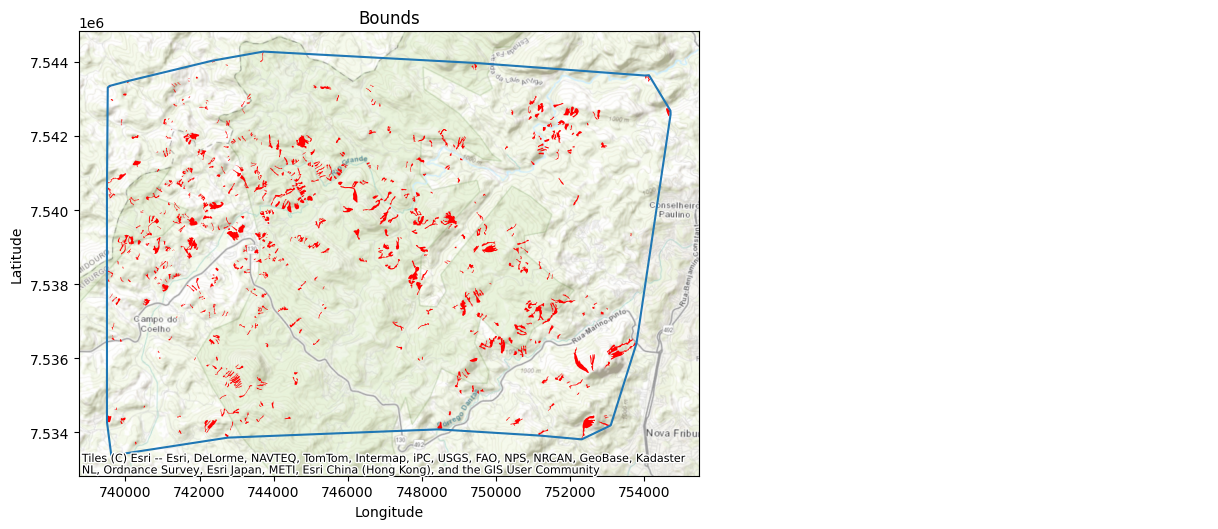

In [12]:
# plot the bounds

# custom bounds
if select_bounds_method.value == options[2]:
    # read bounds from file
    bounds_gpd = gpd.read_file(upload_bounds.value)

    # reproject bounds to the CRS
    bounds_gpd = bounds_gpd.to_crs(CRS)

    # get the total bounds for cropping
    total_bounds = bounds_gpd.total_bounds
    total_bounds_poly = box(*total_bounds)

    # save the bounds poly to file
    bounds_gpd = gpd.GeoDataFrame(geometry=[total_bounds_poly], crs=CRS)
    bounds_gpd.to_file(os.path.join(working_dir, "bounds.geojson"))

    # # save the bounds to file
    # bounds_gpd.to_file(os.path.join(working_dir, "bounds.geojson"))
    # print(f'{time.ctime()}: Saved bounds to {os.path.join(working_dir, "bounds.geojson")}')
elif select_bounds_method.value == options[3]:
    try:
        # get the bounds from the widget
        bounds_gpd = gpd.read_file(upload_bounds.value)
    except:
        pass

# plot the bounds
bounds_ax = bounds_gpd.boundary.plot(figsize=(8, 8))

# add a title to the plot
bounds_ax.set_title("Bounds")

# add axis labels
bounds_ax.set_xlabel("Longitude")
bounds_ax.set_ylabel("Latitude")

# add a basemap to the plot
try:
    cx.add_basemap(bounds_ax, source=cx.providers.Esri.WorldTopoMap, crs=CRS)
except:
    print(f"{time.ctime()}: Failed to add basemap to the plot.")

try:
    # add the masks to the plot
    mask_polygons.plot(ax=bounds_ax, color="red")
except:
    # add the raster to the plot
    with rio.open(mask_path) as src:
        show(src, ax=bounds_ax, cmap="gray")

In [13]:
total_area = bounds_gpd.area[0]
unit = bounds_gpd.crs.axis_info[0].unit_name
print(
    f"{time.ctime()}: Total area of the bounds is {total_area:.2f} in square {unit}s."
)

# calculate the area of the masks
try:
    obj_area = mask_polygons.area.sum()
except:
    with rio.open(mask_path) as src:
        # convert to numpy
        mask = src.read(1)

        # sum where mask is 1
        obj_area = (mask == 1).sum() * src.res[0] ** 2

print(f"{time.ctime()}: Total area of the masks is {obj_area:.2f} square {unit}s.")

ratio = obj_area / total_area
print(f"{time.ctime()}: Ratio of masks to bounds is {ratio:.3f}.")

CLASS_WEIGHTS = {0: 1 - ratio, 1: ratio}

Sun May 12 13:59:38 2024: Total area of the bounds is 146449542.65 in square metres.
Sun May 12 13:59:38 2024: Total area of the masks is 4766368.28 square metres.
Sun May 12 13:59:38 2024: Ratio of masks to bounds is 0.033.


# Data Preparation


## Select tile size & data resolution

<!-- ### What is a tile size?

### Why are tile sizes powers of 2?

### How to choose a tile size -->


The tile size is the size of the image patches in `tile_size * tile_size` pixels that will be extracted from the input data.

The resolution is automatically determined by the input data, but can be modified.

<!-- It is not recommended increase the resolution of the data -->

In [14]:
# set tile size and data resolution
select_tile_size = widgets.Dropdown(
    options=[16, 32, 64, 128, 256, 512],
    value=64,
    description="Tile Size:",
    disabled=False,
)

# set the minimum resolution to be the maximum of the minimum resolution and the maximum resolution
min_res = max(min_res, max_res)

select_res = widgets.BoundedFloatText(
    value=min_res,  # defaults to the maximum of the minimum and maximum resolutions
    min=max_res,
    max=max_res,
    step=0.00001,  # 1 m
    description="Resolution:",
    disabled=False,
)

# combine the widgets into an HBox layout
widget_layout = widgets.HBox([select_tile_size, select_res])


if min_res == max_res:
    print(
        f"{time.ctime()}: Detected only one resolution of {min_res} m from input data."
    )
    select_res.disabled = True

    display(select_tile_size)
else:
    print("For reference:")
    print(
        f"{time.ctime()}: Detected minimum (lowest) resolution of {min_res} m from input data."
    )
    print(
        f"{time.ctime()}: Detected maximum (highest) resolution of {max_res} m from input data."
    )

    select_res = widgets.BoundedFloatText(
        # value=0.00010,  # defaults to 10 m
        min=max_res,
        step=0.00001,  # 1 m
        description="Resolution:",
        disabled=False,
    )

    # combine the widgets into an HBox layout
    widget_layout = widgets.HBox([select_tile_size, select_res])

    # display the layout
    widget_layout

Sun May 12 13:59:38 2024: Detected only one resolution of 5.0 m from input data.


Dropdown(description='Tile Size:', index=2, options=(16, 32, 64, 128, 256, 512), value=64)

## Select vector file features

If you uploaded any features in vector file format, you will be prompted to select which features to use. Vector files may include multiple features, which will need to be encoded as separate bands in the composite/stacked raster used to train the model. If you don't select any features, the function will default to selecting the first feature it finds in the first vector file it searches.

It is recommended that you only select the most relevant features to reduce the time and space complexity of the model (how long and how much memory it takes to run). Additionally, too many inputs may cloud the model's ability to learn the relationship between the inputs and the mask.

> Note that this is not relevant for raster feature files, which will be processed later.

In [15]:
# select features to train on

# set tile & pixel size from widget selections
TILE_SIZE = select_tile_size.value
# PIXEL_SIZE = select_res.value
PIXEL_SIZE = 2

all_col = []

# todo : improve this method instead of forcing an error on tiff files
for path in feature_paths:
    # print(path, feature)
    feature = Path(os.path.basename(path)).stem
    try:  # try to open aka check if its a vector
        gdf = gpd.read_file(path)
        all_col.extend([f"{feature}: {n}" for n in gdf.columns])
        all_col.remove(f"{feature}: geometry")
    except Exception as e:
        # print(f"{time.ctime()}: {e}")
        print(
            f"{time.ctime()}: Feature input {path} is already a raster file, no features need to be extracted."
        )

# select columns to keep
to_keep = widgets.SelectMultiple(
    options=all_col,
    # value=[all_col[0]], # defaults to first feature
    description="Features: ",
    disabled=False,
)

if len(all_col) > 0:
    to_keep.value = [all_col[0]]  # defaults to first feature
    display(to_keep)
else:
    print(f"{time.ctime()}: You do not need to select any input features.")

Sun May 12 13:59:38 2024: Feature input ./working/alos_nova_friburgo_5m.tif is already a raster file, no features need to be extracted.
Sun May 12 13:59:38 2024: You do not need to select any input features.


## Rasterize data


In order for the model to learn from the data, the input feature data will be encoded in raster bands. Therefore, any input features in vector file format will be rasterized using the data resolution selected above.

> Note: Depending on the size of your data, this step may take several minutes to run. In the case of large datasets, it may be more efficient to rasterize the data in a GIS software such as QGIS or ArcGIS and upload the rasterized data.

In [16]:
# rasterize masks and selected features if necessary

# rasterize masks if necessary


try:
    print(f"{time.ctime()}: Attempting to rasterize {mask_path}...")
    gdf = gpd.read_file(mask_path)
    # old_path = mask_path
    # mask_path = os.path.join(working_dir, "mask.tif")
    gdf["encoding_key"] = 1
    os.remove(mask_path)
    gdf.to_file(mask_path)
    to_raster(
        mask_path,
        os.path.join(working_dir, "mask.tif"),
        feature_id="encoding_key",
        pixel_size=select_res.value,
        windows_shape=(2064, 2064),
    )
    mask_path = os.path.join(working_dir, "mask.tif")
except:
    print(f"{time.ctime()}: {mask_path} is already a raster file.")

Sun May 12 13:59:38 2024: Attempting to rasterize ./working/scars.geojson...


In [17]:
# get the feature_ids for the features that need to be turned into bands
keeping = [re.findall(r"\s(.*)", s) for s in to_keep.value]
keeping = list(itertools.chain.from_iterable(keeping))
keeping = list(map(str.lower, keeping))

band_paths = []

# convert the features to rasters if necessary
for feature_path in feature_paths:
    try:
        gdf = gpd.read_file(feature_path)
        gdf.columns = list(map(str.lower, gdf.columns))

        for feature in keeping:
            if feature in gdf.columns:
                fn = feature + ".tif"
                to_raster(
                    feature_path,
                    os.path.join(working_dir, fn),
                    feature_id=feature,
                    pixel_size=PIXEL_SIZE,
                    windows_shape=(4084, 4084),
                )
                band_paths.append(os.path.join(working_dir, fn))
                print(
                    f"{time.ctime()}: {feature} is in {feature_path}, band saved as {fn}."
                )
            else:
                print(f"{time.ctime()}: {feature} is not in {feature_path}")
    except:
        print(f"{time.ctime()}: {feature} is already a raster file.")
        band_paths.append(feature_path)

Sun May 12 13:59:49 2024: alos_nova_friburgo_5m is already a raster file.


## Stack the features into a multiband raster


In [18]:
# make sure all rasters are the same resolution & have x & y dims divisible by 2
with rasterio.open(mask_path) as mask_ds:
    # Loop through the band rasters
    for band_path in tqdm(band_paths):
        with rasterio.open(band_path) as band_ds:
            # Reproject and resample the band raster to match the mask
            with rasterio.open(
                band_path,
                "w",
                driver="GTiff",
                height=mask_ds.height,
                width=mask_ds.width,
                count=band_ds.count,
                dtype=band_ds.dtypes[0],
                crs=mask_ds.crs,
                transform=mask_ds.transform,
                nodata=NO_DATA,
            ) as band_reprojected:
                reproject(
                    source=rasterio.band(band_ds, 1),
                    destination=rasterio.band(band_reprojected, 1),
                    src_transform=band_ds.transform,
                    src_crs=band_ds.crs,
                    dst_transform=mask_ds.transform,
                    dst_crs=mask_ds.crs,
                    resampling=Resampling.bilinear,
                )

# crop to bounds and save to working directory
band_paths_list = es.crop_all(
    [mask_path, *band_paths], working_dir, bounds_gpd, overwrite=True
)

# build a list describing the bands to be stacked in the composite image
band_paths = []
mask_path = ""
for path in band_paths_list:
    if "mask" in path:
        mask_path = path
    else:
        band_paths.append(path)

# create a save path for the stacked bands in the working dir
stack_path = os.path.join(working_dir, "stack.tif")

100%|██████████| 1/1 [00:00<00:00,  2.07it/s]


In [19]:
# read metadata of first band
with rio.open(band_paths[0]) as src:
    meta = src.meta

# count the number of bands in the input layers
band_count = 0
for layer in band_paths:
    with rio.open(layer, "r") as src:
        band_count += src.count

# update meta to reflect the number of layers
meta.update(count=band_count)

# read each layer/band and write it to stack using rasterio
BANDS = {}
id = 1
with rio.open(stack_path, "w", **meta) as dst:
    for layer in band_paths:
        with rio.open(layer, "r") as src:
            for band in range(1, src.count + 1):
                l = Path(layer).stem
                print(
                    f"{time.ctime()}: Writing band {band} from {l} to composite raster."
                )
                dst.write_band(id, src.read(band))
                BANDS[f"{os.path.basename(l)}_BAND-{band}"] = id - 1
                id += 1
        src.close()

print(f"{time.ctime()}: Composite raster saved as {stack_path}.")

Sun May 12 13:59:50 2024: Writing band 1 from alos_nova_friburgo_5m_crop to composite raster.
Sun May 12 13:59:50 2024: Composite raster saved as ./working/stack.tif.


## Data Tiling


### Create tiles

Sun May 12 13:59:50 2024: Created 1476 tiles size 64x64.


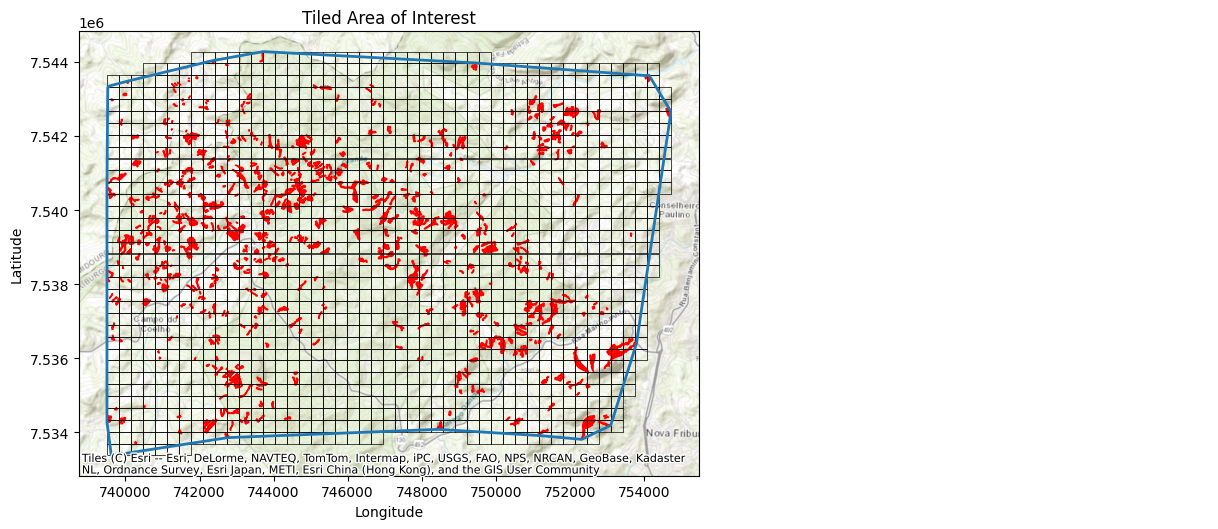

In [20]:
# create a spatial data generator for the mask and data stack
mask_sgd = SpatialDataGenerator(source=mask_path, interleave="pixel")
data_sgd = SpatialDataGenerator(source=stack_path, interleave="pixel")

# create regularly gridded tiles that cover the bounds of the mask w no overlap
tile_bounds_gdf = mask_sgd.regular_grid(TILE_SIZE, TILE_SIZE, overlap=0, units="pixels")

# create a geodataframe of the bounds of the mask
tiles_gdf = tile_bounds_gdf[tile_bounds_gdf.intersects(bounds_gpd.unary_union)].copy()
# tiles_gdf = tile_bounds_gdf.copy()

# print the number of tiles created
print(f"{time.ctime()}: Created {len(tiles_gdf)} tiles size {TILE_SIZE}x{TILE_SIZE}.")

# plot the tiles
tiles_ax = tiles_gdf.boundary.plot(figsize=(8, 8), edgecolor="black", linewidth=0.5)

# add a title to the plot
tiles_ax.set_title("Tiled Area of Interest")

# add axis labels
tiles_ax.set_xlabel("Longitude")
tiles_ax.set_ylabel("Latitude")

# plot the mask polygons underneath the tiles
try:
    # add the masks to the plot
    mask_polygons.plot(ax=tiles_ax, color="red", edgecolor="red")
except:
    # add the raster to the plot
    with rio.open(mask_path) as src:
        show(src, ax=tiles_ax, cmap="gray")

# plot the bounds of the area of interest
bounds_gpd.boundary.plot(ax=tiles_ax, color=None, linewidth=2)

# add a basemap to the plot
cx.add_basemap(tiles_ax, source=cx.providers.Esri.WorldTopoMap, crs=CRS)

### Extract images and masks from tiles

In [21]:
# reshape the data to be in the correct shape for the model

# ensure that the data is in the correct shape for the model

data_sgd.add_preprocess_callback("reshape", lambda x: img_reshape(x, tile_size=TILE_SIZE))
mask_sgd.add_preprocess_callback("reshape", lambda x: img_reshape(x, tile_size=TILE_SIZE))

# create generators for the input data
X_gen = data_sgd.flow_from_dataframe(tiles_gdf, TILE_SIZE, TILE_SIZE, batch_size=1)
Y_gen = mask_sgd.flow_from_dataframe(tiles_gdf, TILE_SIZE, TILE_SIZE, batch_size=1)

# n = len(tiles_gdf) # number of tiles

X = unpack_gen(X_gen)  # unpack the data generator
Y = unpack_gen(Y_gen)  # unpack the mask generator

# reshape the data to be in the correct format for the model
X = X[0, ...].astype(np.float32)
Y = Y[0, ...].astype(np.float32)

Y = np.where(Y > 0, 1, 0)  # binarize the mask

# print(X.shape, Y.shape)
# np.unique(Y)

## Normalize Data

In [22]:
# convert the data to the correct data type
X = np.array(X, dtype=np.float32)
Y = np.array(Y, dtype=np.uint8)

# normalize the images
X_norm = normalize_images(X)

print(
    f"{time.ctime()}: Completed per-channel, per-image normalization of {len(X_norm)} images."
)

Sun May 12 13:59:59 2024: Completed per-channel, per-image normalization of 1476 images.


## Data Visualization

Check to make sure things look good visually


In [23]:
# create three dropdowns to select the band to display
options = list(BANDS.keys())
options.insert(0, "None")
band1 = widgets.Dropdown(options=options, description="Band 1")
band2 = widgets.Dropdown(options=options, description="Band 2")
band3 = widgets.Dropdown(options=options, description="Band 3")

# display the dropdowns in boxes
b = widgets.VBox([band1, band2, band3])
display(b)

In [24]:
bands = []
for c in b.children:
    if c.value != "None":
        bands.append(BANDS[c.value])

r = 5
if not len(bands) == 0:
    n = np.random.randint(0, len(X), r)

    # plot r random tiles in separate images
    for i in range(r):
        spectral.imshow(
            X[n[i], ...],
            bands=bands,
            stretch=True,
            title=f"Tile {n[i]} with Bands {bands}",
            figsize=(3, 3),
        )

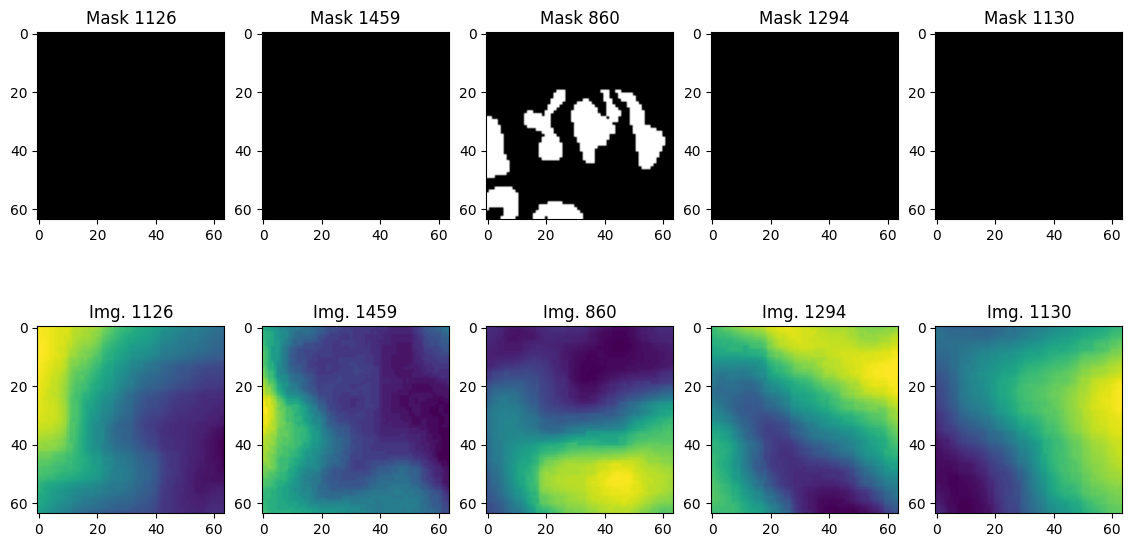

In [25]:
num_channels = X.shape[-1]  # get the number of channels in the input data
num_images = 5  # number of random images to display

fig = plt.figure(figsize=(14, 7))
for i in range(num_images):
    n = np.random.randint(0, len(X))

    ax = fig.add_subplot(2, num_images, i + 1)
    ax.imshow(Y[n, :, :, 0], cmap="Greys_r")
    ax.set_title(f"Mask {n}")

    # images
    # for j in range(num_channels):
    ax = fig.add_subplot(2, num_images, num_images + i + 1)
    ax.imshow(X[n, :, :, 0], cmap="viridis")
    ax.set_title(f"Img. {n}")

## Split Data & Set Parameters

- add info about deciding split ratios and the other params to be selected

In [26]:
train_size = widgets.FloatSlider(
    value=0.65,
    min=0.00,
    max=1.0,
    step=0.01,
    description="Training %:",
    disabled=False,
    continuous_update=True,
    # orientation="vertical",
    readout=True,
    readout_format=".2f",
)

validation_size = widgets.FloatSlider(
    value=0.25,
    min=0.00,
    max=1.0,
    step=0.01,
    description="Validation %:",
    disabled=False,
    continuous_update=True,
    # orientation="vertical",
    readout=True,
    readout_format=".2f",
)

test_size = widgets.FloatSlider(
    value=0.10,
    min=0.00,
    max=1.0,
    step=0.01,
    description="Test %:",
    disabled=False,
    continuous_update=True,
    # orientation="vertical",
    readout=True,
    readout_format=".2f",
)

select_epochs = widgets.IntSlider(
    value=25,
    min=1,
    max=100,
    step=1,
    description="# Epochs:",
    disabled=False,
    continuous_update=True,
    orientation="horizontal",
    readout=True,
    readout_format="d",
)

# should be a factor of 2 to take advantage of the GPU resources
select_batch_size = widgets.Dropdown(
    options=[8, 16, 32, 64, 128],
    value=16,
    description="Batch Size:",
    disabled=False,
)

widgets.VBox([train_size, validation_size, test_size, select_epochs, select_batch_size])

In [27]:
EPOCHS = select_epochs.value  # default = 50
BATCH_SIZE = select_batch_size.value  # default = 32

# validate the splits
# assert int(train_size.value + validation_size.value + test_size.value) == 1

TRAIN_SIZE = train_size.value
VALID_SIZE = validation_size.value
TEST_SIZE = test_size.value

# train test split
print(f"{time.ctime()}: Splitting data into train, validation, and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(
    X_norm, Y, test_size=TEST_SIZE, shuffle=True, random_state=SEED
)

# extricate the validation set from the training set
X_train, X_val, Y_train, Y_val = train_test_split(
    X_train, Y_train, test_size=VALID_SIZE, shuffle=True, random_state=SEED
)

Sun May 12 14:00:01 2024: Splitting data into train, validation, and test sets...


In [28]:
print(f"{time.ctime()}: Dataset sizes:")
print(f"Training: {len(X_train)}")
print(f"Validation: {len(X_val)}")
print(f"Test: {len(X_test)}")

Sun May 12 14:00:01 2024: Dataset sizes:
Training: 996
Validation: 332
Test: 148


## Data Augmentation

- add info about deciding augmentation params

In [29]:
fliplr = widgets.FloatSlider(
    value=0.5,
    min=0.00,
    max=1.0,
    step=0.01,
    description="Flip L/R %:",
    disabled=False,
    continuous_update=True,
    orientation="horizontal",
    readout=True,
    readout_format=".2f",
)

flipud = widgets.FloatSlider(
    value=0.5,
    min=0.00,
    max=1.0,
    step=0.01,
    description="Flip U/D %:",
    disabled=False,
    continuous_update=True,
    orientation="horizontal",
    readout=True,
    readout_format=".2f",
)

transX = widgets.FloatSlider(
    value=0.5,
    min=0.0,
    max=1.0,
    step=0.01,
    description="Translate X %:",
    disabled=False,
    continuous_update=True,
    orientation="horizontal",
    readout=True,
    readout_format=".2f",
)

transY = widgets.FloatSlider(
    value=0.5,
    min=0.0,
    max=1.0,
    step=0.01,
    description="Translate Y %:",
    disabled=False,
    continuous_update=True,
    orientation="horizontal",
    readout=True,
    readout_format=".2f",
)

scaleX = widgets.FloatSlider(
    value=0.5,
    min=0.0,
    max=1.0,
    step=0.01,
    description="Scale X %:",
    disabled=False,
    continuous_update=True,
    orientation="horizontal",
    readout=True,
    readout_format=".2f",
)

scaleY = widgets.FloatSlider(
    value=0.5,
    min=0.0,
    max=1.0,
    step=0.01,
    description="Scale Y %:",
    disabled=False,
    continuous_update=True,
    orientation="horizontal",
    readout=True,
    readout_format=".2f",
)

add_noise = widgets.FloatSlider(
    value=0.5,
    min=0.0,
    max=1.0,
    step=0.01,
    description="Noise %:",
    disabled=False,
    continuous_update=True,
    orientation="horizontal",
    readout=True,
    readout_format=".2f",
)

hist_eq = widgets.FloatSlider(
    value=0.5,
    min=0.0,
    max=1.0,
    step=0.01,
    description="Hist. Eq. %:",
    disabled=False,
    continuous_update=True,
    orientation="horizontal",
    readout=True,
    readout_format=".2f",
)

box = widgets.VBox([fliplr, flipud, transX, transY, scaleX, scaleY, hist_eq])

box

In [30]:
X_pos, Y_pos = filter_images_with_mask(X_train, Y_train)

print(f"{time.ctime()}: Found {len(X_pos)} images with masks.")

Sun May 12 14:00:01 2024: Found 420 images with masks.


In [31]:
# augment all images or just the ones with masks (objs of interest)
augment_all = widgets.RadioButtons(
    options=["Augment only images with masks", "Augment all images"],
    description="Augment all images or just the ones with masks?",
    disabled=False,
)

# choose whether to concatenate augmented or replace the original images
concat_replace = widgets.RadioButtons(
    options=["Concatenate", "Replace"],
    description="Replace or concatenate to original dataset?",
    disabled=False,
)

widgets.VBox([augment_all, concat_replace])

In [32]:
ia.seed(SEED)

seq = iaa.Sequential(
    [
        iaa.Fliplr(fliplr.value),  # LR flip
        iaa.Flipud(flipud.value),  # UD flip
        iaa.Sometimes(
            transX.value, iaa.TranslateX(percent=(-0.1, 0.1))
        ),  # x translation
        iaa.Sometimes(
            transY.value, iaa.TranslateY(percent=(-0.1, 0.1))
        ),  # y translation
        iaa.Sometimes(scaleX.value, iaa.ScaleX(scale=(0.8, 1.2))),  # x scale
        iaa.Sometimes(scaleY.value, iaa.ScaleY(scale=(0.8, 1.2))),  # y scale
        # iaa.AdditiveGaussianNoise(scale=(0, 0.05 * 255), per_channel=True),  # add gaussian noise
        # iaa.Sometimes(
        #     hist_eq.value, iaa.AllChannelsHistogramEqualization()
        # ),  # histogram equalization
    ]
)

if augment_all.value == "Augment all images":
    print(f"{time.ctime()}: Augmenting all images...")
    X_aug, Y_aug = seq(images=X, segmentation_maps=Y)
else:
    print(f"{time.ctime()}: Augmenting images with masks...")
    X_aug, Y_aug = seq(images=X_pos, segmentation_maps=Y_pos)

if concat_replace.value == "Concatenate":
    print(f"{time.ctime()}: Concatenating augmented images to original dataset...")
    X = np.concatenate((X, X_aug), axis=0)
    Y = np.concatenate((Y, Y_aug), axis=0)
else:
    print(f"{time.ctime()}: Replacing original dataset with augmented images...")
    X = X_aug
    Y = Y_aug

print(
    f"{time.ctime()}: Augmentation completed. The dimension of the augmented training dataset is {X.shape}."
)

Sun May 12 14:00:02 2024: Augmenting images with masks...
Sun May 12 14:00:02 2024: Concatenating augmented images to original dataset...
Sun May 12 14:00:02 2024: Augmentation completed. The dimension of the augmented training dataset is (1896, 64, 64, 1).


## Convert to *tf.data.Dataset* format

In [33]:
# transform the numpy arrays into tensorflow datasets
print(f"{time.ctime()}: Transforming numpy arrays into tensorflow datasets...")
train_ds = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
valid_ds = tf.data.Dataset.from_tensor_slices((X_val, Y_val))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

print(f"{time.ctime()}: Batching and parallelizing the datasets...")
# batch the data, drop the remainder, & parallelize according to available resources
train_ds = train_ds.batch(
    BATCH_SIZE, drop_remainder=True, num_parallel_calls=tf.data.AUTOTUNE
)
valid_ds = valid_ds.batch(
    BATCH_SIZE, drop_remainder=True, num_parallel_calls=tf.data.AUTOTUNE
)
test_ds = test_ds.batch(
    BATCH_SIZE, drop_remainder=True, num_parallel_calls=tf.data.AUTOTUNE
)

# use all of data points, 1 batch size at a time
STEPS_PER_EPOCH = len(X_train) // BATCH_SIZE
print(f"{time.ctime()}: Calculated steps per epoch to be: {STEPS_PER_EPOCH}")

# calculate validation steps
VALIDATION_STEPS = len(X_val) // BATCH_SIZE
print(f"{time.ctime()}: Calculated validation steps to be: {VALIDATION_STEPS}")

print(f"{time.ctime()}: Batching and parallelization completed.")

Sun May 12 14:00:02 2024: Transforming numpy arrays into tensorflow datasets...
Sun May 12 14:00:02 2024: Batching and parallelizing the datasets...
Sun May 12 14:00:02 2024: Calculated steps per epoch to be: 62
Sun May 12 14:00:02 2024: Calculated validation steps to be: 20
Sun May 12 14:00:02 2024: Batching and parallelization completed.


# Train the Model


### Pytorch Model

In [34]:
import torch
import torch.nn as nn

from torch.utils.data import TensorDataset, DataLoader

# Define Focal Loss function
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction="mean"):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = nn.BCEWithLogitsLoss(reduction="none")(inputs, targets)
        pt = torch.exp(-BCE_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss

        if self.reduction == "mean":
            return torch.mean(focal_loss)
        elif self.reduction == "sum":
            return torch.sum(focal_loss)
        else:
            return focal_loss


def intersection_over_union(predicted, target, epsilon=1e-8):
    intersection = (predicted * target).sum(
        dim=(1, 2)
    )  # Calculate the intersection for each sample
    union = (predicted + target).sum(
        dim=(1, 2)
    ) - intersection  # Calculate the union for each sample

    iou = (intersection + epsilon) / (
        union + epsilon
    )  # Calculate IoU for each sample, adding epsilon to avoid division by zero

    # Return the mean IoU across all samples
    return iou.mean()

# Convert numpy arrays to tensors with permuted dimensions (N, C, H, W)
X_train_tensor = torch.from_numpy(X_train).permute(0, 3, 1, 2)
Y_train_tensor = torch.from_numpy(Y_train).permute(0, 3, 1, 2)

# Create a TensorDataset
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)

# Create a train dataloader
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# print shapes
print("X_train_tensor:", X_train_tensor.shape)
print("Y_train_tensor:", Y_train_tensor.shape)

# repeat for validation data loader
X_val_tensor = torch.from_numpy(X_val).permute(0, 3, 1, 2)
Y_val_tensor = torch.from_numpy(Y_val).permute(0, 3, 1, 2)

val_dataset = TensorDataset(X_val_tensor, Y_val_tensor)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

print("\nX_val_tensor:", X_val_tensor.shape)
print("Y_val_tensor:", Y_val_tensor.shape)

# repeat for test data loader
X_test_tensor = torch.from_numpy(X_test).permute(0, 3, 1, 2)
Y_test_tensor = torch.from_numpy(Y_test).permute(0, 3, 1, 2)

test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

print("\nX_test_tensor:", X_test_tensor.shape)
print("Y_test_tensor:", Y_test_tensor.shape)

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, filters=32):
        super(UNet, self).__init__()
        self.float()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, filters, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(filters, filters, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(filters, filters, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(filters, filters, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(filters, filters, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(filters, filters, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(filters, out_channels, kernel_size=2, stride=2),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x1 = self.encoder(x)
        x2 = self.decoder(x1)
        return x2

X_train_tensor: torch.Size([996, 1, 64, 64])
Y_train_tensor: torch.Size([996, 1, 64, 64])

X_val_tensor: torch.Size([332, 1, 64, 64])
Y_val_tensor: torch.Size([332, 1, 64, 64])

X_test_tensor: torch.Size([148, 1, 64, 64])
Y_test_tensor: torch.Size([148, 1, 64, 64])


## Model Architecture

In [35]:
# build a unet
def bottleneck(inputs, n):
    conv = Conv2D(n, (3, 3), activation="relu", padding="same")(inputs)
    conv = Conv2D(n, (3, 3), activation="relu", padding="same")(conv)

    return conv


def downsample(inputs, n):
    conv = Conv2D(n, (3, 3), activation="relu", padding="same")(inputs)
    conv = Conv2D(n, (3, 3), activation="relu", padding="same")(conv)
    pool = MaxPooling2D((2, 2))(conv)
    # pool = Dropout(0.25)(pool)

    return conv, pool, n * 2


def upsample(inputs, residual, n):
    n = n // 2
    deconv = Conv2DTranspose(n, (3, 3), strides=(2, 2), padding="same")(inputs)
    uconv = concatenate([deconv, residual])
    # uconv = Dropout(0.5)(uconv)
    uconv = Conv2D(n, (3, 3), activation="relu", padding="same")(uconv)
    uconv = Conv2D(n, (3, 3), activation="relu", padding="same")(uconv)

    return uconv, n


def build_unet(input_shape, n=32):
    inputs = Input(shape=input_shape)

    # downsample
    conv1, pool1, n = downsample(inputs, n)
    conv2, pooreg, n = downsample(pool1, n)
    conv3, pool3, n = downsample(pool2, n)
    conv4, pool4, n = downsample(pool3, n)

    # bottleneck
    conv5 = bottleneck(pool4, n)

    # upsample
    uconv4, n = upsample(conv5, conv4, n)
    uconv3, n = upsample(uconv4, conv3, n)
    uconv2, n = upsample(uconv3, conv2, n)
    uconv1, n = upsample(uconv2, conv1, n)

    outputs = Conv2D(1, (1, 1), activation="sigmoid")(uconv1)

    return Model(inputs=[inputs], outputs=[outputs])

In [36]:
# unet w batch norm & dropout
reg = tf.keras.regularizers.l1_l2()

def double_conv_block(x, n_filters):
    # conv2D then ReLU activation
    x = Conv2D(
        n_filters,
        3,
        padding="same",
        activation="relu",
        kernel_initializer="he_normal",
        # kernel_regularizer=reg,
    )(x)
    # conv2D then ReLU activation
    x = Conv2D(
        n_filters,
        3,
        padding="same",
        activation="relu",
        kernel_initializer="he_normal",
        # kernel_regularizer=reg,
    )(x)

    return x


def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)  # feature map
    f = BatchNormalization()(f)  # batch normalization
    p = MaxPool2D(2)(f)  # pooled feature map
    p = Dropout(0.2)(p)  # dropout

    return f, p


def upsample_block(x, conv_features, n_filters):
    # upsample
    x = UpSampling2D()(x)
    x = Conv2D(
        n_filters,
        2,
        padding="same",
        kernel_initializer="he_normal",
        # kernel_regularizer=reg,
    )(x)
    # x = Conv2DTranspose(filters=n_filters, kernel_size=3, strides=(2, 2), padding="same")(x)
    # concatenate
    x = concatenate([x, conv_features])
    # dropout
    x = Dropout(0.2)(x)
    # Conv2D twice with ReLU activation
    x = double_conv_block(x, n_filters)
    # batch normalization
    x = BatchNormalization()(x)

    return x


def build_unet(input_shape, output_channels, depth=5, base_filters=64):
    # inputs
    inputs = Input(shape=input_shape)

    # encoder: contracting path - downsample
    skips = []
    filters = []
    p = inputs
    for i in range(depth):
        nf = base_filters * 2**i
        f, p = downsample_block(p, nf)
        skips.append(f)
        filters.append(nf)

    # bottleneck
    bottleneck = double_conv_block(p, base_filters * 2**depth)

    # decoder: expanding path - upsample
    u = bottleneck
    for i in reversed(range(depth)):
        u = upsample_block(u, skips[i], filters[i])

    # check if output channels is 1 (binary) or > 1 (multiclass)
    if output_channels == 1:
        a_func = "sigmoid"
        print(
            f"{time.ctime()}: Using sigmoid activation function for binary semantic segmentation."
        )
    else:
        a_func = "softmax"
        print(
            f"{time.ctime()}: Using softmax activation function for multiclass semantic segmentation."
        )

    # outputs
    outputs = Conv2D(output_channels, 1, padding="same", activation=a_func)(u)

    # U-Net model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

    return unet_model

In [37]:
import tensorflow as tf
from tensorflow.keras import layers


class Net(object):
    def __init__(
        self,
        input_shape,
        output_channels,
        filters=32,
        depth=3,
        dilation_rates=[1],
        reduction_ratio=16,
        name="model",
    ):
        self.input_shape = input_shape
        self.output_channels = output_channels
        self.filters = filters
        self.depth = depth
        self.dilation_rates = dilation_rates
        self.reduction_ratio = reduction_ratio
        self.name = name
        self.skips = []
        self.inputs = tf.keras.Input(shape=input_shape)

    def channel_attention(self, inputs):
        # channel attention
        channels = inputs.shape[-1]
        avg_pool = layers.GlobalAveragePooling2D()(inputs)
        fc1 = layers.Dense(channels // self.reduction_ratio)(avg_pool)
        fc1 = layers.ReLU()(fc1)
        fc2 = layers.Dense(channels)(fc1)
        fc2 = layers.Activation("sigmoid")(fc2)
        reshaped = layers.Reshape((1, 1, channels))(fc2)
        return layers.Multiply()([inputs, reshaped])

    def spatial_attention(self, inputs, kernel_size=5):
        # spatial attention
        spatial_attn = layers.Conv2D(1, kernel_size, padding="same")(inputs)
        spatial_attn = layers.Activation("sigmoid")(spatial_attn)
        return layers.Multiply()([inputs, spatial_attn])

    def CBAM_block(self, inputs):
        # conv
        x = layers.Conv2D(self.filters, 3, padding="same")(inputs)
        # bn + relu
        x = layers.BatchNormalization()(x)
        # channel attention
        channel_attention_output = self.channel_attention(inputs, self.reduction_ratio)
        # spatial attention
        spatial_attention_output = self.spatial_attention(inputs)
        # merge
        output = layers.Add()([channel_attention_output, spatial_attention_output])
        return output

    def pyramid_pooling_block(self, inputs, bin_sizes=[1, 2, 3, 6]):
        h, w, c = inputs.shape[1:]
        pooled_outputs = []  # store pooled output tensors for each bin size
        # remove invalid bin sizes
        bin_sizes = [size for size in bin_sizes if min(h, w) % size == 0]
        # print("bin sizes", bin_sizes)
        for size in bin_sizes:  # iterate over each bin size
            x = layers.AveragePooling2D(pool_size=(h // size, w // size))(inputs)
            x = layers.Conv2D(self.filters, 1, padding="same")(x)
            x = layers.ReLU()(x)
            # resize so all pooled output tensors have the same shape
            x = layers.Reshape((h, w, -1))(x)
            pooled_outputs.append(x)
        # concatenate pooled output tensors
        x = layers.Concatenate(axis=-1)(pooled_outputs)
        # conv block
        x = layers.Conv2D(self.filters, 3, padding="same")(x)
        x = layers.ReLU()(x)
        x = layers.BatchNormalization()(x)
        # conv block
        x = layers.Conv2D(self.filters, 1, padding="same")(x)
        x = layers.ReLU()(x)
        x = layers.BatchNormalization()(x)
        return x

    # residual block with atrous convolutions
    def residual_block(self, inputs):
        x = inputs
        stack = [x]
        for rate in self.dilation_rates:
            # conv block 1
            x = layers.Conv2D(self.filters, 3, padding="same", dilation_rate=rate)(x)
            x = layers.ReLU()(x)
            x = layers.BatchNormalization()(x)
            # conv block 2
            x = layers.Conv2D(self.filters, 1, padding="same", dilation_rate=rate)(x)
            x = layers.ReLU()(x)
            x = layers.BatchNormalization()(x)
            # apply channel-wise attention
            se = self.channel_attention(x)
            # add to stack to combine parallel atrous convolutions
            stack.append(se)
        # print([s.shape for s in stack])
        x = layers.Add()(stack)
        return x

    def encoding_block(self, inputs):
        # residual block
        x = self.residual_block(inputs)
        # enhance skip with spatial attention
        skip = self.spatial_attention(x)
        # update filters
        self.filters *= 2
        # downsampling with conv2d
        x = layers.Conv2D(self.filters, 1, 2, padding="same")(skip)
        return x, skip

    def decoding_block(self, inputs):
        # calculate new number of filters
        self.filters //= 2
        # upsample the feature maps
        x = layers.UpSampling2D()(inputs)
        # concatenate skip connection from the corresponding encoding block
        x = layers.Concatenate(axis=-1)([x, self.skips.pop()])
        # residual block
        stack = []
        for rate in self.dilation_rates:
            # conv block 1
            x = layers.Conv2D(self.filters, 3, padding="same", dilation_rate=rate)(x)
            x = layers.ReLU()(x)
            x = layers.BatchNormalization()(x)
            # conv block 2
            x = layers.Conv2D(self.filters, 1, padding="same", dilation_rate=rate)(x)
            x = layers.ReLU()(x)
            x = layers.BatchNormalization()(x)
            # apply channel-wise attention
            se = self.channel_attention(x)
            # add to stack to combine parallel atrous convolutions
            stack.append(se)
        # print([s.shape for s in stack])
        x = layers.Add()(stack)
        return x

    def bridge_block(self, inputs):
        # conv block
        x = layers.Conv2D(self.filters, 3, padding="same")(inputs)
        x = layers.ReLU()(x)
        x = layers.BatchNormalization()(x)

        # psp block
        # x = self.PSPPooling_block(inputs)

        # conv block
        x = layers.Conv2D(self.filters, 3, padding="same")(x)
        x = layers.ReLU()(x)
        x = layers.BatchNormalization()(x)

        # cbam block
        # x = self.CBAM_block(x)

        # residual block
        # x = self.residual_block(x)
        return x

    def build(self):
        # input block - inc to initial desired filter size
        x = self.inputs
        x = layers.Conv2D(self.filters, kernel_size=(1, 1), padding="same")(x)
        x = self.spatial_attention(x)
        self.skips.append(x)

        x = self.residual_block(x)

        # encoding path
        for _ in range(self.depth):
            # print(self.filters, x.shape)
            x, skip = self.encoding_block(x)
            self.skips.append(skip)

        # bridge
        # print("bridge", self.filters)
        x = self.bridge_block(x)
        # x = self.CBAM_block(x)

        # decoding path
        for _ in range(self.depth):
            x = self.decoding_block(x)
            # print(self.filters, x.shape)

        # check if multiclass or binary classification
        if self.output_channels > 1:
            a_fn = "softmax"
        else:
            a_fn = "sigmoid"

        # psp block

        # get final skip connection from stack
        x = layers.Concatenate(axis=-1)([x, self.skips.pop()])
        # output segmentation map
        outputs = layers.Conv2D(
            self.output_channels, 1, padding="same", activation=a_fn
        )(x)
        print(self.input_shape, outputs.shape)
        return tf.keras.Model(inputs=self.inputs, outputs=outputs, name=self.name)

In [38]:
# todo add widgets for hyperparameter tuning (sliders galore)

# hyperparams to think about:

# - train, valid, test size, tile size, pixel size
# - epochs, batch size, optimizer, loss functions, accuracy metrics
# - call backs, early stopping, patience
# select loss function


# select optimizer


# select metrics

In [39]:
import tensorflow as tf
from tensorflow.keras.losses import BinaryCrossentropy


def dice_coefficient(y_true, y_pred, smooth=1e-5):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice_coeff = (2.0 * intersection + smooth) / (union + smooth)

    return dice_coeff


def weighted_dice_loss(class_proportions):
    def loss(y_true, y_pred):
        dice = dice_coefficient(y_true, y_pred)

        # compute weights based on class proportions
        weights = tf.constant(class_proportions, dtype=tf.float32)

        # index 0: background; 1: foreground
        weighted_dice = tf.multiply(y_true * weights[1], dice) + tf.multiply(
            (1.0 - y_true) * weights[0], dice
        )
        return 1.0 - tf.reduce_mean(weighted_dice)

    return loss


def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        # Convert labels to tensors
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        # Calculate binary crossentropy
        binary_cross_entropy = BinaryCrossentropy()(y_true, y_pred)

        # Calculate focal loss
        p_t = (y_true * y_pred) + ((1 - y_true) * (1 - y_pred))
        modulating_factor = tf.pow(1.0 - p_t, gamma)
        focal_loss = modulating_factor * binary_cross_entropy

        # Apply class balancing
        weighted_focal_loss = alpha * focal_loss

        return tf.reduce_mean(weighted_focal_loss)

    return focal_loss_fixed

In [40]:
# tf.keras.utils.plot_model(
#     model, show_shapes=False, to_file=os.path.join(working_dir, "model_architecture.png")
# )

In [41]:
# define model parameters
# BATCH_SIZE = 32
INPUT_SHAPE = (TILE_SIZE, TILE_SIZE, band_count)  # X.shape[-1])

# compile model

# IF BINARY SEG, OUTPUT_CHANNELS = 1
model = build_unet(input_shape=INPUT_SHAPE, output_channels=1, base_filters=32, depth=3)
# model = Net(INPUT_SHAPE, output_channels=1, filters=16, depth=3).build()
print(f"{time.ctime()}: Model compiled successfully.")

# define metrics
metrics = [
    # "accuracy",
    # tf.keras.metrics.Accuracy(),
    tf.keras.metrics.BinaryAccuracy(),
    tf.keras.metrics.BinaryIoU(),
    # dice_coefficient,
    # tf.keras.metrics.Precision(),
    # tf.keras.metrics.Recall(),
    # tfa.metrics.F1Score(num_classes=1, average='macro', threshold=0.5),
    # tfa.metrics.MatthewsCorrelationCoefficient(num_classes=2, threshold=0.5),
    tf.keras.losses.BinaryCrossentropy(),
]

# tf.keras.metrics.BinaryIoU(), tf.keras.metrics.FalseNegatives(), tf.keras.metrics.FalsePositives(), tf.keras.metrics.TrueNegatives(), tf.keras.metrics.TruePositives()]

# loss = tfa.losses.SigmoidFocalCrossEntropy()

class_weights = list(CLASS_WEIGHTS.values())

# Free up RAM in case the model definition cells were run multiple times
tf.keras.backend.clear_session()

model.summary()

Sun May 12 14:00:03 2024: Using sigmoid activation function for binary semantic segmentation.
Sun May 12 14:00:03 2024: Model compiled successfully.
Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 64, 64, 32)   9248        ['conv2d[0][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 

## Training

In [42]:
# Compile the model with the learning rate scheduler
model.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(1e-3, 100, 0.96)
    ),
    # loss=tf.keras.losses.BinaryFocalCrossentropy(apply_class_balancing=True),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=metrics,
)

# todo add widget for setting output directory for model
output_dir = os.path.join(working_dir, "models")
file_name = f"model_{datetime.now()}"
file_name = file_name.replace(" ", "_").replace(":", "-").replace(".", "-")
model_path = os.path.join(output_dir, file_name + ".keras") # uses *.keras file format

print(f"{time.ctime()}: Model will be saved to {model_path}")

from tensorflow.keras.callbacks import ModelCheckpoint

# set up callbacks
checkpoint = ModelCheckpoint(
    filepath=model_path,
    monitor="val_binary_crossentropy",
    mode="auto",
    save_best_only=True,
    restore_best_weights=True,
    save_freq="epoch",
    verbose=1,
)

# keep track of the model training progression
h = tf.keras.callbacks.History()

callbacks = [
    checkpoint,
    tf.keras.callbacks.EarlyStopping(
        patience=3, monitor="val_binary_crossentropy", mode="auto"
    ),
    tf.keras.callbacks.TensorBoard(log_dir=os.path.join(working_dir, "logs")),
    h,
]

Sun May 12 14:00:03 2024: Model will be saved to ./working/models/model_2024-05-12_14-00-03-567888.keras


In [43]:
EPOCHS = 25

In [44]:
# print model training details
print(f"{time.ctime()}: Model training details:")
print(f"Model name: {model.name}")
print(f"Input shape: {INPUT_SHAPE}")
print(f"Epochs: {EPOCHS}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Steps per epoch: {STEPS_PER_EPOCH}")
print(f"Validation steps: {VALIDATION_STEPS}")
print(f"Loss function: {model.loss}")
print(f"Optimizer: {model.optimizer}")
# print(f"Metrics: {model.metrics}")

Sun May 12 14:00:03 2024: Model training details:
Model name: U-Net
Input shape: (64, 64, 1)
Epochs: 25
Batch size: 16
Steps per epoch: 62
Validation steps: 20
Loss function: <keras.losses.BinaryCrossentropy object at 0x16274f940>
Optimizer: <keras.optimizers.optimizer_experimental.adam.Adam object at 0x16180beb0>


In [45]:
# train model
# import coiled
# @coiled.function(
#     cpu=8,
#     idle_timeout="15s"
#     # package_sync_ignore=['GDAL', 'alphashape']
# )
def train():
    history = model.fit(
        X_train,
        Y_train,
        # train_ds,  # batch size is determined by the dataset
        epochs=100,
        steps_per_epoch=STEPS_PER_EPOCH,
        # validation_data=valid_ds,
        validation_data=(X_val, Y_val),
        validation_steps=VALIDATION_STEPS,
        callbacks=callbacks,
        verbose=1,
    )
    return history

train()

Epoch 1/100
62/62 [==============================] - ETA: 0s - loss: 0.5952 - binary_accuracy: 0.8600 - binary_io_u: 0.4428 - binary_crossentropy: 0.5945
Epoch 1: val_binary_crossentropy improved from inf to 0.45611, saving model to ./working/models/model_2024-05-12_14-00-03-567888.keras
62/62 [==============================] - 82s 1s/step - loss: 0.5952 - binary_accuracy: 0.8600 - binary_io_u: 0.4428 - binary_crossentropy: 0.5945 - val_loss: 0.4559 - val_binary_accuracy: 0.9612 - val_binary_io_u: 0.4819 - val_binary_crossentropy: 0.4561
Epoch 2/100
62/62 [==============================] - ETA: 0s - loss: 0.3703 - binary_accuracy: 0.9696 - binary_io_u: 0.4852 - binary_crossentropy: 0.3698
Epoch 2: val_binary_crossentropy improved from 0.45611 to 0.28265, saving model to ./working/models/model_2024-05-12_14-00-03-567888.keras
62/62 [==============================] - 79s 1s/step - loss: 0.3703 - binary_accuracy: 0.9696 - binary_io_u: 0.4852 - binary_crossentropy: 0.3698 - val_loss: 0.282

# Results


## Calculate Performance Metrics


In [46]:
best_model = tf.keras.models.load_model(
    model_path,
    custom_objects={
        # "loss": weighted_dice_loss(class_weights),
        # "dice_coefficient": dice_coefficient,
        "BinaryCrossentropy": tf.keras.losses.BinaryCrossentropy(),
    },
)  #                                        'focal_loss': semseglosses.focal_loss })

# use the model to make predictions on the reserved test data
score = best_model.evaluate(X_test, Y_test, verbose=1)
# print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

5/5 [==============================] - 4s 567ms/step - loss: 0.1179 - binary_accuracy: 0.9753 - binary_io_u: 0.4876 - binary_crossentropy: 0.1140


## Visualize Results

In [47]:
# Display n random images with their masks and predicted masks
random_indices = np.random.choice(range(len(X_test)), size=3, replace=False)

# Iterate over the randomly selected images
for idx in random_indices:
    # Get the original image (first three channels)
    original_image = X_test[idx][:, :, 4]

    # Get the true mask and predicted mask
    true_mask = Y_test[idx]
    predicted_mask = best_model.predict(X_test[idx].reshape(-1, 32, 32, 6))
    predicted_mask = np.squeeze(predicted_mask)
    predicted_mask = (predicted_mask > 0.2).astype(np.uint8)

    # Plotting the images
    fig, axs = plt.subplots(1, 3, figsize=(5, 5))
    axs[0].imshow(original_image)
    axs[0].set_title("Original Image")

    axs[1].imshow(true_mask, cmap="gray")
    axs[1].set_title("True Mask")

    axs[2].imshow(predicted_mask, cmap="gray")
    axs[2].set_title("Predicted Mask")

    plt.show()

IndexError: index 4 is out of bounds for axis 2 with size 1

In [ ]:
END_TIME = time.time()
print(f"{time.ctime()}:  Elapsed time: {END_TIME - START_TIME}")